fine-tuning Model  
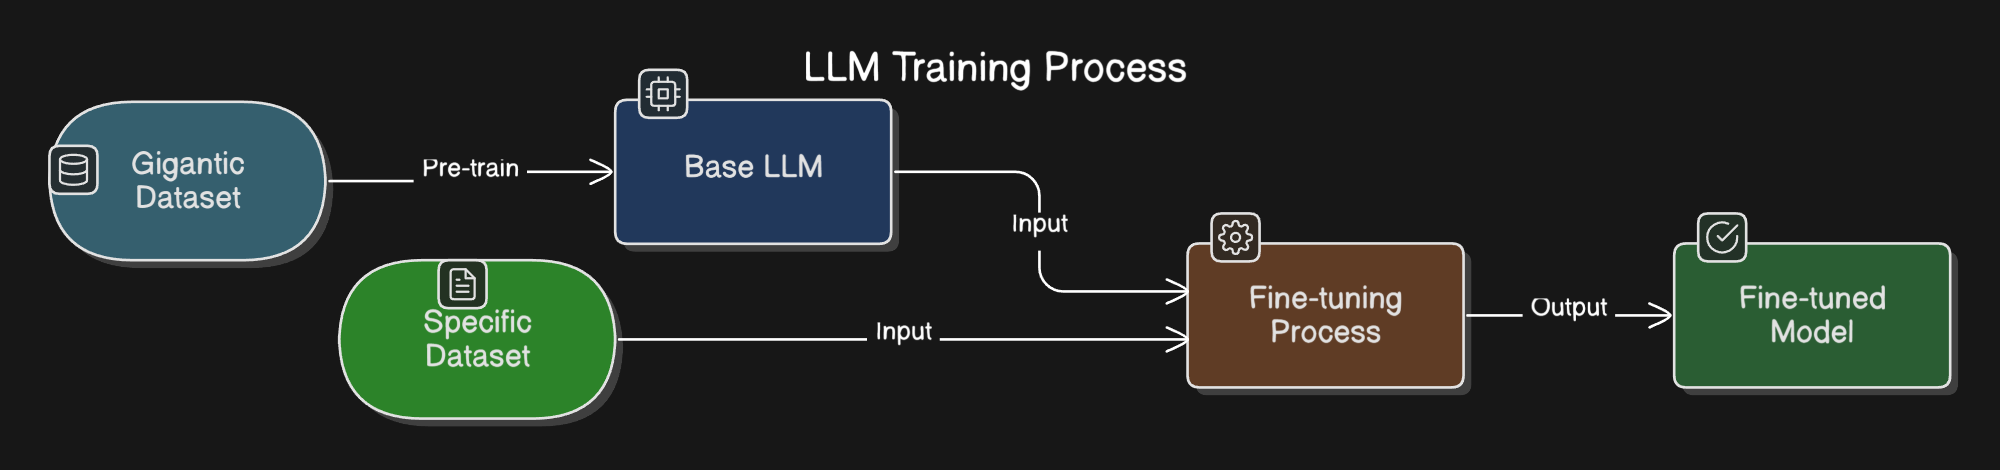


In [1]:
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
import numpy as np


c:\Users\RJSA-13-06-2024-03\.conda\envs\Vatsalya_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Dataset 
dataset = load_dataset("mteb/tweet_sentiment_extraction")
# Spliting dataset (80% train, 20% test)
dataset = dataset["train"].train_test_split(test_size=0.2)

In [3]:
# Loading Tokenizer & Set Padding Token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token, so use EOS
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"].remove_columns(["text"])
eval_dataset = tokenized_datasets["test"].remove_columns(["text"])


Map: 100%|██████████| 5497/5497 [00:00<00:00, 5569.47 examples/s]


In [4]:
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
model.config.pad_token_id = tokenizer.eos_token_id  # Set padding token in model config


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Data Collator for Proper Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [6]:
# Defining Accuracy Metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [7]:
# 7️⃣ ⚙️ Set Training Arguments (Force GPU & Optimize)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Reduce if GPU memory runs out
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,  # ✅ Enable Mixed Precision (Boosts speed on GPUs)
    logging_dir="./logs",
    logging_steps=10,
)


c:\Users\RJSA-13-06-2024-03\.conda\envs\Vatsalya_env\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

#Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,  # ✅ Ensure correct tokenizer is used
    data_collator=data_collator,  # ✅ Use collator to handle padding
    compute_metrics=compute_metrics,
)

# Start Training
trainer.train()

# Evaluate the Model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Save the Model & Tokenizer for Future Use
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")
print("Model saved successfully!")


Map: 100%|██████████| 5497/5497 [00:00<00:00, 5696.13 examples/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\RJSA-13-06-2024-03\AppData\Local\Temp\ipykernel_8464\3690759416.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.481400,0.558281,0.770966
2,0.651600,0.524831,0.784974
3,0.327700,0.544035,0.789703


Evaluation Results: {'eval_loss': 0.5440348982810974, 'eval_accuracy': 0.7897034746225213, 'eval_runtime': 125.8582, 'eval_samples_per_second': 43.676, 'eval_steps_per_second': 0.683, 'epoch': 3.0}
Model saved successfully!


In [8]:
import torch
# Load the trained model
model_path = "./saved_model"
model = GPT2ForSequenceClassification.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [10]:
def predict_sentiment(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    # Move tensors to GPU if available
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted label
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Map label to sentiment (adjust based on dataset labels)
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = label_map[predicted_class]

    return sentiment

In [13]:
# Example texts for sentiment prediction
examples = [
    "While the book had an interesting premise and a few genuinely gripping moments, I couldn't shake the feeling that the pacing was inconsistent, and some characters felt underdeveloped. However, the author's prose was engaging.",
    "This software update fixed several major bugs that were frustrating users, and the UI improvements are a nice touch. That said, there's still a lot of room for optimization, as some features remain unintuitive and sluggish.",
    "Despite the team's best efforts, the game ultimately falls short of expectations. The graphics are breathtaking, and the world-building is immersive, yet the gameplay mechanics feel clunky, and the story lacks emotional depth.",
    "I love this product! It's amazing.",
    "The movie was okay, not the best but not the worst.",
    "I hate waiting in long lines. It's frustrating!"
]

# Run predictions
for text in examples:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")

Text: While the book had an interesting premise and a few genuinely gripping moments, I couldn't shake the feeling that the pacing was inconsistent, and some characters felt underdeveloped. However, the author's prose was engaging.
Predicted Sentiment: Neutral

Text: This software update fixed several major bugs that were frustrating users, and the UI improvements are a nice touch. That said, there's still a lot of room for optimization, as some features remain unintuitive and sluggish.
Predicted Sentiment: Neutral

Text: Despite the team's best efforts, the game ultimately falls short of expectations. The graphics are breathtaking, and the world-building is immersive, yet the gameplay mechanics feel clunky, and the story lacks emotional depth.
Predicted Sentiment: Neutral

Text: I love this product! It's amazing.
Predicted Sentiment: Positive

Text: The movie was okay, not the best but not the worst.
Predicted Sentiment: Neutral

Text: I hate waiting in long lines. It's frustrating!
P